In [58]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Tuple
from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.interpolate import griddata

PI = np.pi

In [59]:
sigma = 10

In [60]:
def unwrap1D(arr: np.array, period: Optional[float] = 6.2831853072, axis: Optional[int] = 0) -> np.array:
    """
    Unwrap a 1D phase array along a specified axis, ignoring NaNs.

    Parameters
    ----------
    arr : np.ndarray
        Input array containing phase values to be unwrapped.

    period : float, optional
        The period of the phase (default is 2π).
        This defines the maximum allowed jump between values before unwrapping occurs.

    axis : int, optional
        The axis along which to unwrap the phase (default is 0).

    Returns
    -------
    np.ndarray
        The unwrapped phase array of the same shape as `arr`.

    Notes
    -----
    This function is similar to numpy's unwrap but with additional support for handling NaNs.
    The function unrolls the phase by changing absolute jumps greater than the specified period to their 2π complement.

    See Also
    --------
    np.unwrap : Numpy's function for unwrapping phase arrays.

    Examples
    --------
    >>> import numpy as np
    >>> x = np.linspace(0, 50)
    >>> x_wrapped = x % (2 * np.pi)
    >>> x_unwrapped = unwrap1D(x_wrapped)
    >>> print(np.allclose(x, x_unwrapped))
    True

    """

    assert isinstance(axis, int) and (axis >= 0), f"[unwrap1D] 'axis' must be an integer (here, 'axis'={axis})."
    assert axis < len(arr.shape), f"[unwrap1D] The array has only {len(arr.shape)} dimensions, so 'axis' must be between 0 and {len(arr.shape)-1} (here, 'axis'={axis})."

    # Permute the specified axis to be the first axis
    arr = np.moveaxis(arr, axis, 0)
    arr_copy = np.copy(arr)

    # Reshape the array to 2D for easier handling
    original_shape = arr_copy.shape
    arr_copy = arr_copy.reshape(arr_copy.shape[0], -1)

    # Iterate over the second dimension and beyond
    for i in range(arr_copy.shape[1]):
        column = arr_copy[:, i]

        # Identify non-NaN indices
        valid_idx = ~np.isnan(column)
        valid_data = column[valid_idx]

        # Compute differences and identify jumps
        diffs = np.diff(valid_data, prepend=0)
        jumps = -np.round(diffs / period) * period

        # Apply jumps
        arr_copy[valid_idx, i] = valid_data + np.cumsum(jumps)

    # Restore the original shape and axis order
    arr_copy = arr_copy.reshape(original_shape)
    arr_unwrapped = np.moveaxis(arr_copy, 0, axis)

    return arr_unwrapped

Lecture du fichier Matlab

In [61]:
def read_mat_file(file_path):
    data = scipy.io.loadmat(file_path)
    return data

def split_3d_array(array_3d):
    # Ensure the array has the expected shape
    if array_3d.shape[2] != 5:
        raise ValueError("The loaded array does not have the expected third dimension size of 5.")
    
    # Extract the 2D arrays
    arrays = [array_3d[:, :, i].astype(float) for i in range(5)]
    return arrays

def selection_surface_utile(mask):
    a, b = mask.shape

    xmin = 0
    while xmin < a and np.sum(mask[xmin, :]) == 0:
        xmin += 1

    xmax = a - 1
    while xmax > 0 and np.sum(mask[xmax, :]) == 0:
        xmax -= 1

    ymin = 0
    while ymin < b and np.sum(mask[:, ymin]) == 0:
        ymin += 1

    ymax = b - 1
    while ymax > 0 and np.sum(mask[:, ymax]) == 0:
        ymax -= 1

    mask_select = mask[xmin:xmax+1, ymin:ymax+1]

    return mask_select, xmin, xmax, ymin, ymax

def hariharan_algorithm(intensity_1: np.ndarray, intensity_2: np.ndarray, intensity_3: np.ndarray, intensity_4: np.ndarray, intensity_5: np.ndarray) -> np.ndarray:
    num = 2 * (intensity_4 - intensity_2)
    denum = 2 * intensity_3 - intensity_5 - intensity_1
    return np.arctan2(num, denum)

In [62]:
def unwrap1(xe: np.ndarray, sautLimite: float = PI, dim: Optional[int] = None) -> np.ndarray:
    P = 2 * sautLimite
    sxe = np.shape(xe)
    if dim is None:
        dim = 0
        xe = np.squeeze(xe)
    else:
        dim -= 1
        xe = np.moveaxis(xe, dim, 0)

    yd = xe.copy()
    for j in range(sxe[dim]):
        y = yd[j]
        k = ~np.isnan(y)
        ysn = y[k]
        dysn = np.diff(ysn, prepend=0)
        saut = -np.round(dysn / P) * P
        yd[j, k] = ysn + np.cumsum(saut)

    if dim != 0:
        yd = np.moveaxis(yd, 0, dim)
    return yd

def unwrap2D(Ph: np.ndarray):
    def unwrap2Dc(Ph: np.ndarray):
        def supprimeNaN(x1: np.ndarray, x2: np.ndarray):
            in1 = np.isnan(x1)
            in2 = np.isnan(x2)
            both = (~in1) & (~in2)

            offset = np.mean(x2[both] - x1[both])
            y = x1.copy()
            y[in1 & (~in2)] = x2[in1 & (~in2)] - offset

            k = np.where(np.isnan(y))[0]
            Lk = len(k)

            if Lk != 0:
                dk = np.diff(k)
                dk = np.append(dk, 0)

                iDF = np.zeros((0, 2))
                j = 0
                while j < Lk:
                    iDF = np.append(iDF, [[k[j], k[j]]], axis=0)
                    while j < Lk and dk[j] == 1:
                        j += 1
                        iDF[-1, 1] = k[j]
                    j += 1

                if iDF[0, 0] == 0:
                    iDF = iDF[1:]

                if len(iDF) > 0 and iDF[-1, 1] == len(x1) - 1:
                    iDF = iDF[:-1]

                for j in range(len(iDF)):
                    if abs(y[iDF[j, 0] - 1] - y[iDF[j, 1] + 1]) < 1e-10:
                        y[iDF[j, 0]:iDF[j, 1] + 1] = y[iDF[j, 0] - 1]
            return y

        PhD = unwrap1D(Ph)
        N = Ph.shape[0]
        isnPh = np.isnan(Ph)
        nbNaNparLigne = np.sum(isnPh, axis=1)

        l1 = np.argmin(nbNaNparLigne)
        L1 = PhD[l1]
        coef = 0.025
        delta = int(np.ceil(N * coef))
        i_rej = np.arange(max(1, l1 - delta), min(N, l1 + delta))
        k_rej = np.setdiff1d(np.arange(N), i_rej)
        l2 = np.argmin(nbNaNparLigne[k_rej])
        if l2 > min(i_rej):
            l2 += len(i_rej)
        L2 = PhD[l2]

        LD1 = unwrap1D(L1)
        sautL1 = LD1 - L1
        LD2 = unwrap1D(L2)
        sautL2 = LD2 - L2

        sautLsN = supprimeNaN(sautL1, sautL2)

        sautM = np.outer(np.ones(N), sautLsN)

        PhD = PhD + sautM
        return PhD

    PhDc = unwrap2Dc(Ph)
    PhDl = unwrap2Dc(Ph.T).T
    isnPh = np.isnan(Ph)
    isnPl = np.isnan(Ph.T).T

    both = (~isnPh) & (~isnPl)

    Voffset = PhDc[both] - PhDl[both]
    offsetBrut = np.mean(Voffset)
    offset = 2 * PI * round(offsetBrut / (2 * PI))
    ecarto = abs(offset - offsetBrut)

    pb = np.abs(PhDc - PhDl - offset) > PI / 10000

    Voffset = PhDc[both[:]&~pb[:]] - PhDl[both[:]&~pb[:]]
    if len(Voffset) >=2:
        offsetBrut = np.mean(Voffset)
        offset = 2*PI*np.round(offsetBrut/(2*PI))
        ecarttype = np.std(Voffset)
    else:
        ecarttype = np.inf

    NbPPb = np.sum(pb)
    NbBoth = np.sum(both)
    rapp = NbPPb / NbBoth

    ecarttype = np.std(Voffset)  # Calcul de l'écart-type

    info = [ecarto, ecarttype, rapp]

    tauxMaxPtsDiff = 0.05

    if rapp > tauxMaxPtsDiff or ecarttype > PI / 10000:
        Pb = True
        PhD = PhDc.copy()
        PhD[~both] = np.nan
        PhD[pb] = np.nan
    else:
        Pb = False
        PhD = PhDc.copy()
        PhD[isnPh & (~isnPl)] = PhDl[isnPh & (~isnPl)] + offset

        k, m = np.where(pb)
        for idx in range(len(k)):
            if k[idx] in [0, Ph.shape[0] - 1] or m[idx] in [0, Ph.shape[1] - 1]:
                PhD[k[idx], m[idx]] = np.nan
            else:
                errc = np.diff(PhDc[k[idx], m[idx] + (-1, 0, 1)])
                errc = errc[~np.isnan(errc)]
                errl = np.diff(PhDl[k[idx] + (-1, 0, 1), m[idx]])
                errl = errl[~np.isnan(errl)]

                Pbc = np.any(np.abs(errc) > PI)
                Pbl = np.any(np.abs(errl) > PI)

                if Pbc and Pbl:
                    PhD[k[idx], m[idx]] = np.nan
                elif Pbc:
                    PhD[k[idx], m[idx]] = PhDl[k[idx], m[idx]] + offset
                elif Pbl:
                    pass
                else:
                    PhD[k[idx], m[idx]] = np.nan
                    
    return PhD, Pb, info, both, pb

In [63]:
def suppression_bord(phi, p):
    a, b = phi.shape

    phi2 = np.full((a + 20, b + 20), np.nan)
    phi2[10:a + 10, 10:b + 10] = phi

    MatrixNaN = 100 * np.isnan(phi2)

    # Utilisation du filtre moyen (équivalent à fspecial('average', p) en MATLAB)
    H = np.ones((p, p)) / (p * p)
    maskinverse = uniform_filter(MatrixNaN, size=p)

    maskinverse[maskinverse != 0] = 1

    for i in range(a + 20):
        for j in range(b + 20):
            if maskinverse[i, j] != 0:
                phi2[i, j] = np.nan

    MatrixNotNaN = ~np.isnan(phi2)

    mask, xmin, xmax, ymin, ymax = selection_surface_utile(MatrixNotNaN)

    phi2 = phi2[xmin:xmax, ymin:ymax]

    return phi2

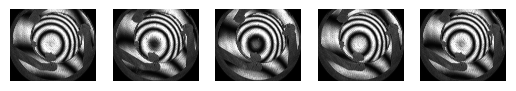

In [64]:
data = read_mat_file("/Users/dorianmendes/Desktop/SupOptique/1A/Stage & Admisseur/Stage LEnsE/camera-gui-repository/applis/Zygo-labwork/_data/imgs2.mat")
images = data['Imgs']
images = split_3d_array(images)

for i, img in enumerate(images):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

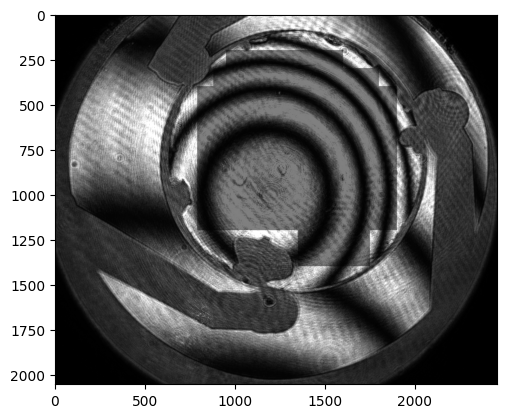

In [65]:
mask = np.zeros_like(images[0])
mask[400:1200, 790:1900] = 1
mask[200:400, 950:1600] = 1
mask[300:400, 880:1800] = 1
mask[1200:1400, 1350:1750] = 1

plt.imshow(images[0], cmap='magma')
plt.imshow(images[0]*(1-mask/2), cmap='gray')

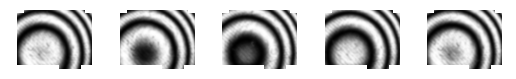

[2.043254454520138e-11, 1.8660695258725965e-14, 0.0]


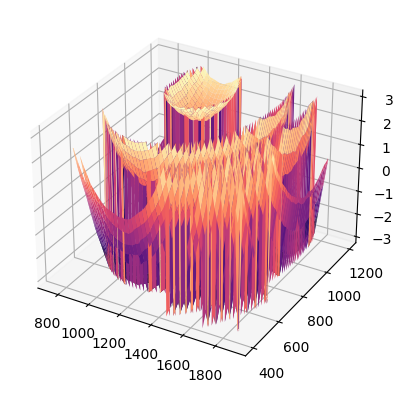

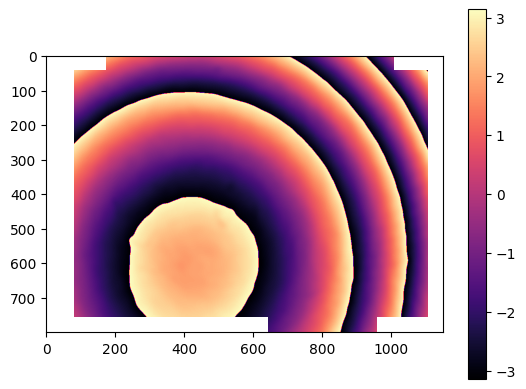

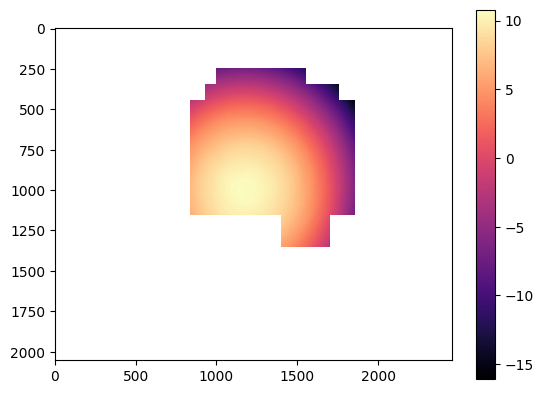

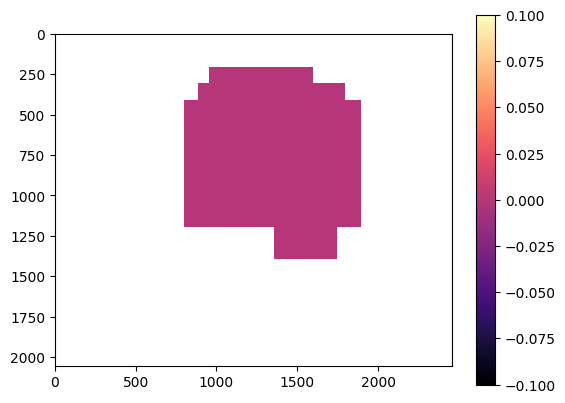

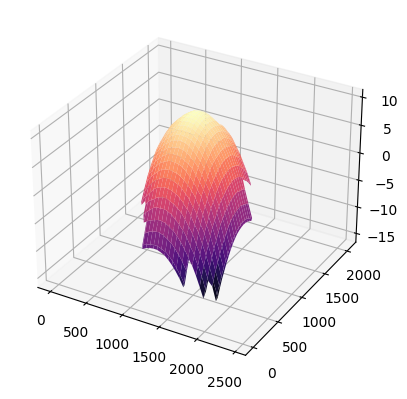

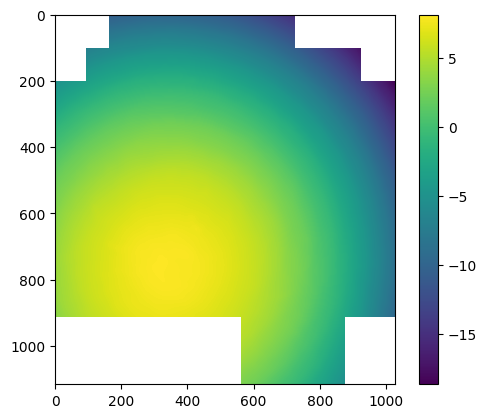

In [66]:

for image in images:
    image[mask==0] = np.nan
    image = image[400:1200, 750:1900]

images_filtrees = list(map(lambda x:gaussian_filter(x, sigma), images))

for i, img in enumerate(images_filtrees):
    plt.subplot(1,5,i+1)
    plt.imshow(img[400:1200, 750:1900], cmap='gray')
    plt.axis('off')
plt.show()

phase = hariharan_algorithm(*images_filtrees)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(phase.shape[1]); y = np.arange(phase.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x[400:1200, 750:1900], y[400:1200, 750:1900], phase[400:1200, 750:1900], cmap='magma')

plt.figure()
plt.imshow(phase[400:1200, 750:1900], cmap='magma')
plt.colorbar()

unwrapped_phase, _, info, both, pb = unwrap2D(phase)
unwrapped_phase *= -1
#[400:1200, 750:1900]

print(info)

plt.figure()
plt.imshow(unwrapped_phase, cmap='magma')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(pb*images[0], cmap='magma')
plt.colorbar()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(unwrapped_phase.shape[1]); y = np.arange(unwrapped_phase.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x, y, unwrapped_phase, cmap='magma')
plt.show()

phi = suppression_bord(unwrapped_phase, 3)
phi = phi - np.nanmean(phi)
plt.imshow(phi)
plt.colorbar()
plt.show()

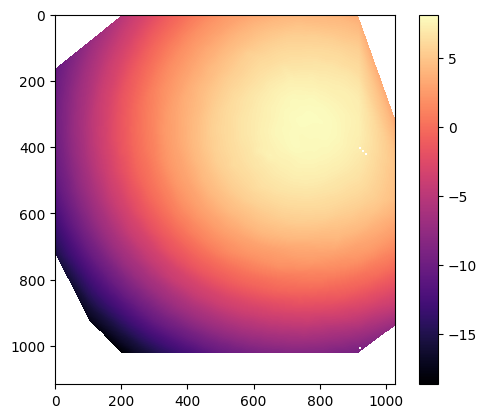

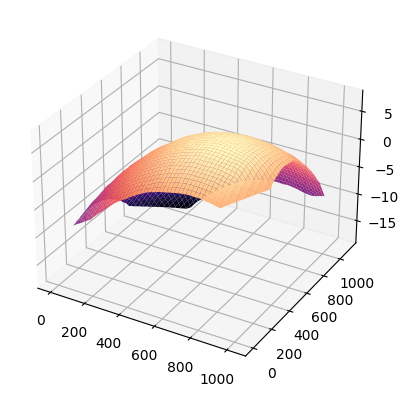

In [67]:
not_nan_indices = np.where(~np.isnan(phi))

# Récupérez les valeurs non-nan et leurs coordonnées
values = phi[not_nan_indices]
x = not_nan_indices[0]
y = not_nan_indices[1]

# Générer une grille de points pour l'interpolation
x_grid, y_grid = np.meshgrid(np.arange(phi.shape[1]), np.arange(phi.shape[0]))

# Interpolez les valeurs manquantes
interpolated_values = griddata((x, y), values, (x_grid, y_grid), method='linear')
#interpolated_values = gaussian_filter(interpolated_values, 3)

# Affichage de l'interpolation
plt.imshow(interpolated_values, cmap='magma')
plt.colorbar()
plt.show()

# Affichage en 3D de l'interpolation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(interpolated_values.shape[1])
y = np.arange(interpolated_values.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x, y, interpolated_values, cmap='magma')
plt.show()

In [68]:
phase_zygo = read_mat_file('C:/Users/LEnsE/Documents/GitHub/camera-gui/applis/Zygo-labwork/_data/phase2.mat')['surface_absoustr']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(phase_zygo.shape[1])
y = np.arange(phase_zygo.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x, y, phase_zygo, cmap='magma')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/LEnsE/Documents/GitHub/camera-gui/applis/Zygo-labwork/_data/phase2.mat'

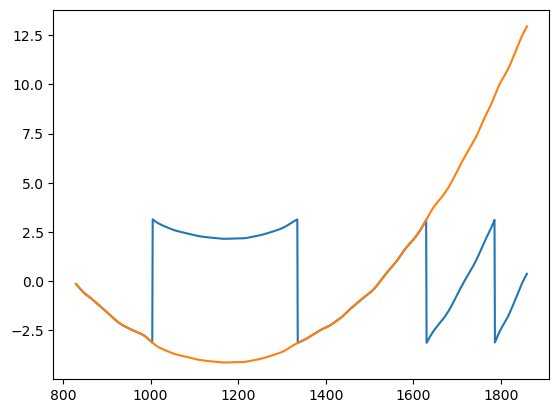

In [ ]:
plt.plot(phase[1100,:])
plt.plot(unwrap1D(phase,axis=1)[1100,:])

***
***